# Building a FAISS-Based Vector Store: A Journey Through Data Processing and Visualization

In this notebook, you'll learn how to transform raw PDF documents into a searchable vector store using FAISS. We'll go on a journey where we:

1. **Read and extract text from PDF files.**
2. **Split the text into manageable chunks.**
3. **Display tokenization outputs from different tokenizers.**
4. **Generate embeddings from the text using a SentenceTransformer.**
5. **Store the embeddings in a FAISS index.**
6. **Project the embeddings into 2D space using UMAP for visualization.**
7. **Visualize the entire process on a scatter plot.**
8. **Incect your data into a prompt for a large language model**

In [3]:
import os
import tqdm
import glob
from PyPDF2 import PdfReader
from langchain.text_splitter import RecursiveCharacterTextSplitter
from sentence_transformers import SentenceTransformer
from langchain.text_splitter import SentenceTransformersTokenTextSplitter
from langchain_community.embeddings import HuggingFaceEmbeddings  # For generating embeddings for text chunks
import faiss
import pickle
import matplotlib.pyplot as plt
import umap.umap_ as umap
import numpy as np
from dotenv import load_dotenv
from groq import Groq


c:\Users\lowja\Documents\RAG-and-embeddings-KIA\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
import os
import tqdm
import glob
from PyPDF2 import PdfReader
from langchain.text_splitter import RecursiveCharacterTextSplitter
from sentence_transformers import SentenceTransformer
from langchain.text_splitter import SentenceTransformersTokenTextSplitter
from langchain_community.embeddings import HuggingFaceEmbeddings  # For generating embeddings for text chunks
import faiss
import pickle
import matplotlib.pyplot as plt
import umap.umap_ as umap
import numpy as np
from dotenv import load_dotenv
from groq import Groq


## 1. Reading Data from PDFs

First, we load PDF files from a directory, extract their text content, and combine it into one large text string.

In [5]:
### load the pdf from the path
glob_path = "data/*.pdf"
text = ""
for pdf_path in tqdm.tqdm(glob.glob(glob_path)):
    with open(pdf_path, "rb") as file:
        print(file)
        reader = PdfReader(file)
         # Extract text from all pages in the PDF
        text += " ".join(page.extract_text() for page in reader.pages if page.extract_text())

text[:50]

 11%|█         | 1/9 [00:00<00:01,  6.92it/s]

<_io.BufferedReader name='data\\02_Merkblatt_Vermeidung-von-Plagiaten_0916.pdf'>
<_io.BufferedReader name='data\\05_Checkliste_Sprachliche_Formale_Ausarbeitung.pdf'>


 33%|███▎      | 3/9 [00:00<00:00, 13.10it/s]

<_io.BufferedReader name='data\\Bibliotheksangebot_Bachelorarbeit_HS24FS25.pdf'>
<_io.BufferedReader name='data\\Schwerpunktthemen_fuer_Studenten.pdf'>
<_io.BufferedReader name='data\\W_MB_Merkblatt_Bachelorarbeit_BSc.pdf'>


 56%|█████▌    | 5/9 [00:00<00:00,  4.45it/s]

<_io.BufferedReader name='data\\ZHAW_Zitierleitfaden_DE.pdf'>


 67%|██████▋   | 6/9 [00:02<00:01,  2.23it/s]

<_io.BufferedReader name='data\\Z_MB_Merkblatt_Verwendung_von_generativer_KI_in_Arbeiten.pdf'>


 78%|███████▊  | 7/9 [00:02<00:00,  2.44it/s]

<_io.BufferedReader name='data\\Z_RL_Richtlinie_Anhang_Deklarationspflicht_KI_bei_Arbeiten.pdf'>


 89%|████████▉ | 8/9 [00:02<00:00,  2.49it/s]

<_io.BufferedReader name='data\\Z_RL_Richtlinie_KI_bei_Leistungsnachweisen.pdf'>


100%|██████████| 9/9 [00:03<00:00,  2.95it/s]


' \n \n \n \n \n \n2.2.5.1 -01MB Vermeidung von Plagiaten'

## 2. Splitting the Text into Chunks

Large texts can be difficult to work with. We use a text splitter, in this case [RecursiveCharacterTextSplitter](https://python.langchain.com/docs/how_to/recursive_text_splitter/),  to break the full text into smaller, overlapping chunks. This helps preserve context when we later embed the text.

In [6]:
# Create a splitter: 2000 characters per chunk with an overlap of 200 characters
splitter = RecursiveCharacterTextSplitter(chunk_size=2000, chunk_overlap=200)
# Split the extracted text into manageable chunks
chunks = splitter.split_text(text)

In [7]:
print(f"Total chunks: {len(chunks)}")
print("Preview of the first chunk:", chunks[0][:200])

Total chunks: 61
Preview of the first chunk: 2.2.5.1 -01MB Vermeidung von Plagiaten  Dok.- Verantw.:  mart 
Version 2.0   
. 
Genehmigt  19.9.12  durch: Generalsekretär   Seite 1 von 2 
 Rektorat  
 
Ressort Lehre  
 
Merkblatt zur Vermeidung vo


## 3. Tokenizing the Text with Different Tokenizers

Before embedding, it's insightful to see how different tokenizers break up our text. Here, we use the tokenizer from the SentenceTransformer model (see [SentenceTransformersTokenTextSplitter](https://python.langchain.com/api_reference/text_splitters/sentence_transformers/langchain_text_splitters.sentence_transformers.SentenceTransformersTokenTextSplitter.html#sentencetransformerstokentextsplitter)).

In [8]:
token_splitter = SentenceTransformersTokenTextSplitter(chunk_overlap=0, tokens_per_chunk=128, model_name="paraphrase-multilingual-MiniLM-L12-v2")

c:\Users\lowja\Documents\RAG-and-embeddings-KIA\.venv\Lib\site-packages\huggingface_hub\file_download.py:143: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\lowja\.cache\huggingface\hub\models--sentence-transformers--paraphrase-multilingual-MiniLM-L12-v2. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)
Xet Storage is enabled for this repo, but the 'hf_xet' 

In [9]:
token_split_texts = []
for text in chunks:
    token_split_texts += token_splitter.split_text(text)

print(f"\nTotal chunks: {len(token_split_texts)}")
print(token_split_texts[0])


Total chunks: 252
2.2.5.1 -01MB Vermeidung von Plagiaten Dok.- Verantw.: mart Version 2.0 . Genehmigt 19.9.12 durch: Generalsekretär Seite 1 von 2 Rektorat Ressort Lehre Merkblatt zur Vermeidung von Plagiaten Plagiate verstossen gegen grundlegende Regeln wissenschaftlichen Arbeitens. Entsprechend s e- hen das Gesetz und die Rahmenprüfungsordnung für Bachelor - und Masterstudi engänge der ZHAW (RPO) in Plagiatsfällen zum Teil gravierende Sanktionen für Studierende vor. Dieses Mer k- blatt soll 


In [10]:
model_name = "paraphrase-multilingual-MiniLM-L12-v2"
model = SentenceTransformer(model_name)
tokenized_chunks = []
for i, text in enumerate(token_split_texts[:10]):
    # Tokenize each chunk
    encoded_input = model.tokenizer(text, padding=True, truncation=True, max_length=128, return_tensors='pt')
    # Convert token IDs back to tokens
    tokens = model.tokenizer.convert_ids_to_tokens(encoded_input['input_ids'][0].tolist())
    tokenized_chunks.append(tokens)
    print(f"Chunk {i}: {tokens}")

Chunk 0: ['<s>', '▁2.2', '.', '5.1', '▁', '-01', 'MB', '▁Verme', 'i', 'dung', '▁von', '▁Pla', 'gia', 'ten', '▁Dok', '.', '-', '▁Ver', 'ant', 'w', '.', ':', '▁mart', '▁Version', '▁2.0', '▁', '.', '▁Ge', 'nehm', 'igt', '▁19', '.9.', '12', '▁durch', ':', '▁General', 'sekretär', '▁Seite', '▁1', '▁von', '▁2', '▁Rektor', 'at', '▁Res', 'sort', '▁Lehr', 'e', '▁Merk', 'blatt', '▁zur', '▁Verme', 'i', 'dung', '▁von', '▁Pla', 'gia', 'ten', '▁Pla', 'gia', 'te', '▁vers', 'to', 'ssen', '▁gegen', '▁grundlegende', '▁Regeln', '▁', 'wissenschaftlich', 'en', '▁Arbeiten', 's', '.', '▁Ent', 'sprechen', 'd', '▁s', '▁e', '-', '▁hen', '▁das', '▁Gesetz', '▁und', '▁die', '▁Rahmen', 'prüfung', 's', 'ordnung', '▁für', '▁Bachelor', '▁-', '▁und', '▁Master', 'studi', '▁en', 'gänge', '▁der', '▁Z', 'HA', 'W', '▁(', 'R', 'PO', ')', '▁in', '▁Pla', 'gia', 'ts', 'fälle', 'n', '▁zum', '▁Teil', '▁gravi', 'erende', '▁San', 'ktion', 'en', '▁für', '▁Studi', 'erende', '▁vor', '.', '▁Dieses', '▁Mer', '▁k', '-', '▁', 'blatt', '</s

In [11]:
model_name = "Sahajtomar/German-semantic"
model = SentenceTransformer(model_name)
tokenized_chunks = []
for i, text in enumerate(token_split_texts[:10]):
    # Tokenize each chunk
    encoded_input = model.tokenizer(text, padding=True, truncation=True, max_length=128, return_tensors='pt')
    # Convert token IDs back to tokens
    tokens = model.tokenizer.convert_ids_to_tokens(encoded_input['input_ids'][0].tolist())
    tokenized_chunks.append(tokens)
    print(f"Chunk {i}: {tokens}")

c:\Users\lowja\Documents\RAG-and-embeddings-KIA\.venv\Lib\site-packages\huggingface_hub\file_download.py:143: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\lowja\.cache\huggingface\hub\models--Sahajtomar--German-semantic. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


Chunk 0: ['[CLS]', '2', '.', '2', '.', '5', '.', '1', '-', '01', '##MB', 'Vermeidung', 'von', 'Pla', '##gia', '##ten', 'Dok', '.', '-', 'Veran', '##tw', '.', ':', 'mar', '##t', 'Version', '2', '.', '0', '.', 'Genehm', '##igt', '19', '.', '9', '.', '12', 'durch', ':', 'Generalsekretär', 'Seite', '1', 'von', '2', 'Rektor', '##at', 'Ressort', 'Lehre', 'Merk', '##blatt', 'zur', 'Vermeidung', 'von', 'Pla', '##gia', '##ten', 'Pla', '##gia', '##te', 'verst', '##ossen', 'gegen', 'grundlegende', 'Regeln', 'wissenschaft', '##lichen', 'Arbeiten', '##s', '.', 'Entsprechend', 's', 'e', '-', 'hen', 'das', 'Gesetz', 'und', 'die', 'Rahmen', '##prüfung', '##sor', '##dn', '##ung', 'für', 'Bachelor', '-', 'und', 'Masters', '##tu', '##di', 'eng', '##änge', 'der', 'Z', '##H', '##AW', '(', 'R', '##PO', ')', 'in', 'Pla', '##gia', '##ts', '##fällen', 'zum', 'Teil', 'grav', '##ierende', 'Sanktionen', 'für', 'Studierende', 'vor', '.', 'Dieses', 'Mer', 'k', '-', 'bl', '##att', 'soll', '[SEP]']
Chunk 1: ['[CLS]',

## 4. Generating Embeddings for Each Chunk

Now we convert each text chunk into a numerical embedding that captures its semantic meaning. These embeddings will be used for similarity search.

In [12]:
embeddings = HuggingFaceEmbeddings(model_name="paraphrase-multilingual-MiniLM-L12-v2")
chunk_embeddings = model.encode(token_split_texts, convert_to_numpy=True)

C:\Users\lowja\AppData\Local\Temp\ipykernel_29492\4090508586.py:1: LangChainDeprecationWarning: The class `HuggingFaceEmbeddings` was deprecated in LangChain 0.2.2 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-huggingface package and should be used instead. To use it run `pip install -U :class:`~langchain-huggingface` and import as `from :class:`~langchain_huggingface import HuggingFaceEmbeddings``.
  embeddings = HuggingFaceEmbeddings(model_name="paraphrase-multilingual-MiniLM-L12-v2")


## 5. Building a FAISS Vector Store

FAISS is a powerful library for efficient similarity search. Here, we build an index from our embeddings. Remember, FAISS only stores the numerical vectors so we must keep our original text mapping separately.

In [13]:
d = chunk_embeddings.shape[1]
print(d)

1024


In [14]:
index = faiss.IndexFlatL2(d)
index.add(chunk_embeddings)
print("Number of embeddings in FAISS index:", index.ntotal)

Number of embeddings in FAISS index: 252


In [15]:
if not os.path.exists('faiss'):
    os.makedirs('faiss')
    
faiss.write_index(index, "faiss/faiss_index.index")
with open("faiss/chunks_mapping.pkl", "wb") as f:
    pickle.dump(chunks, f)

In [16]:
index_2 = faiss.read_index("faiss/faiss_index.index")
with open("faiss/chunks_mapping.pkl", "rb") as f:
    token_split_texts_2 = pickle.load(f)
print(len(token_split_texts_2))
print(len(token_split_texts))

61
252


## 6. Projecting Embeddings with UMAP

To visualize high-dimensional embeddings, we use UMAP to project them into 2D space. You can project both the entire dataset and individual query embeddings.

In [17]:
# Fit UMAP on the full dataset embeddings
umap_transform = umap.UMAP(random_state=0, transform_seed=0).fit(chunk_embeddings)

def project_embeddings(embeddings, umap_transform):
    """
    Project a set of embeddings using a pre-fitted UMAP transform.
    """
    umap_embeddings = np.empty((len(embeddings), 2))
    for i, embedding in enumerate(tqdm.tqdm(embeddings, desc="Projecting Embeddings")):
        umap_embeddings[i] = umap_transform.transform([embedding])
    return umap_embeddings


c:\Users\lowja\Documents\RAG-and-embeddings-KIA\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\lowja\Documents\RAG-and-embeddings-KIA\.venv\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


In [18]:
# Project the entire dataset embeddings
projected_dataset_embeddings = project_embeddings(chunk_embeddings, umap_transform)
print("Projected dataset embeddings shape:", projected_dataset_embeddings.shape)

Projecting Embeddings:   0%|          | 0/252 [00:00<?, ?it/s]c:\Users\lowja\Documents\RAG-and-embeddings-KIA\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
Projecting Embeddings:   0%|          | 1/252 [00:13<54:54, 13.13s/it]c:\Users\lowja\Documents\RAG-and-embeddings-KIA\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\lowja\Documents\RAG-and-embeddings-KIA\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\lowja\Documents\RAG-and-embeddings-KIA\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and w

Projected dataset embeddings shape: (252, 2)


## 7. Querying the Vector Store and Projecting Results

We now define a retrieval function that takes a text query, embeds it, and searches our FAISS index for similar documents. We then project these result embeddings with UMAP.
"""

In [19]:
def retrieve(query, k=5):
    """
    Retrieve the top k similar text chunks and their embeddings for a given query.
    """
    query_embedding = model.encode([query], convert_to_numpy=True)
    distances, indices = index.search(query_embedding, k)
    retrieved_texts = [token_split_texts[i] for i in indices[0]]
    retrieved_embeddings = np.array([chunk_embeddings[i] for i in indices[0]])
    return retrieved_texts, retrieved_embeddings, distances[0]

In [20]:
query = "KI während der Bachelorarbeit"
results, result_embeddings, distances = retrieve(query, k=3)
print("Retrieved document preview:")
print(results[0][:300])

Retrieved document preview:
(2012). Die Chefs von morgen: Kompetent und kritisch. io Management, 2012(5), 12-15. Zitierleitfaden | 19 Zitierleitfaden | 20 Generative Systeme, die auf Künstlicher Intelligenz (KI) basieren, gehören zunehmend zur neuen Studien- und Berufsrealität von Lehrenden und Lernenden. Die Richtlinie KI bei


In [21]:
# Project the result embeddings
projected_result_embeddings = project_embeddings(result_embeddings, umap_transform)

# Also embed and project the original query for visualization
query_embedding = model.encode([query], convert_to_numpy=True)
project_original_query = project_embeddings(query_embedding, umap_transform)

Projecting Embeddings:   0%|          | 0/3 [00:00<?, ?it/s]c:\Users\lowja\Documents\RAG-and-embeddings-KIA\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\lowja\Documents\RAG-and-embeddings-KIA\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\lowja\Documents\RAG-and-embeddings-KIA\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
Projecting Embeddings:   0%|          | 0/1 [00:00<?, ?it/s]c:\Users\lowja\Documents\RAG-and-embeddings-KIA\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be remov

## 8. Visualizing the Results

Finally, we create a scatter plot to visualize the entire dataset, the retrieved results, and the original query in 2D space.

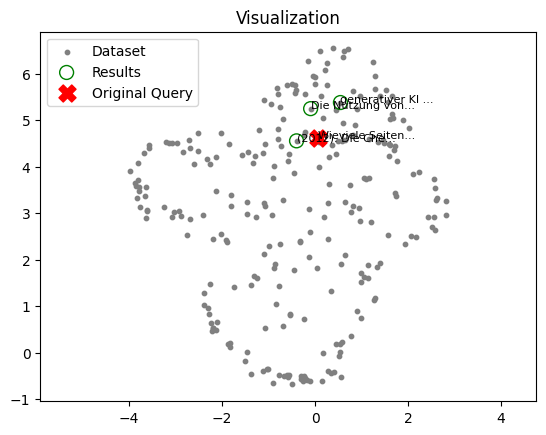

In [22]:

def shorten_text(text, max_length=15):
    """Shortens text to max_length and adds an ellipsis if shortened."""
    return (text[:max_length] + '...') if len(text) > max_length else text

plt.figure()

# Scatter plots
plt.scatter(projected_dataset_embeddings[:, 0], projected_dataset_embeddings[:, 1],
            s=10, color='gray', label='Dataset')
plt.scatter(projected_result_embeddings[:, 0], projected_result_embeddings[:, 1],
            s=100, facecolors='none', edgecolors='g', label='Results')
plt.scatter(project_original_query[:, 0], project_original_query[:, 1],
            s=150, marker='X', color='r', label='Original Query')

# If results is a list of texts, iterate directly
for i, text in enumerate(results):
    if i < len(projected_result_embeddings):
        plt.annotate(shorten_text(text),
                     (projected_result_embeddings[i, 0], projected_result_embeddings[i, 1]),
                     fontsize=8)

# Annotate the original query point
original_query_text = 'Welche hilfsmittel sind erlaubt?'  # Replace with your actual query text if needed
original_query_text = 'Wieviele Seiten muss die Arbeit sein?'  # Replace with your actual query text if needed

plt.annotate(shorten_text(original_query_text),
             (project_original_query[0, 0], project_original_query[0, 1]),
             fontsize=8)

plt.gca().set_aspect('equal', 'datalim')
plt.title('Visualization')
plt.legend()
plt.show()


---

# 📝 Task: Semantic Retrieval-Augmented Question Answering Using Groq LLM

## Objective
Implement a question-answering system that:
1. Retrieves the most semantically relevant text passages to a user query.
2. Constructs a natural language prompt based on the retrieved content.
3. Uses a large language model (LLM) hosted by Groq to generate an answer.

---

## Task Breakdown

### 1. Embedding-Based Semantic Retrieval
- Use the `SentenceTransformer` model `"Sahajtomar/German-semantic"` to encode a user query into a dense vector embedding.
- Perform a nearest-neighbor search in a prebuilt FAISS index to retrieve the top-**k** similar text chunks. You can **use the prebuilt FAISS form above**.


### 2. LLM Prompt Construction and Query Answering
- Build the prompt:
  - Using the retrieved text chunks, concatenates the results into a context block.
  - Builds a **prompt** asking the LLM to answer the question using that context.
  - Sends the prompt to the **Groq LLM API** (`llama-3.3-70b-versatile`) and returns the response.

### 3. User Query Execution
- An example query (`"What is the most important factor in diagnosing asthma?"`) is used to demonstrate the pipeline.
- The final answer from the LLM is printed.


## Tools & Models Used
- **SentenceTransformers** (`Sahajtomar/German-semantic`) for embedding generation.
- **FAISS** for efficient vector similarity search.
- **Groq LLM API** (`llama-3.3-70b-versatile`) for generating the final response.


In [23]:
load_dotenv()
# Access the API key using the variable name defined in the .env file
groq_api_key = os.getenv("GROQ_API_KEY")

In [25]:
import faiss
import pickle
import numpy as np
from sentence_transformers import SentenceTransformer
from groq import Groq

# 1. Laden des vorhandenen FAISS-Index und der zugehörigen Textchunks
def load_faiss_index_and_chunks(index_path="faiss/faiss_index.index", chunks_path="faiss/chunks_mapping.pkl"):
    """
    Lädt den vorhandenen FAISS-Index und die zugehörigen Textchunks.
    
    Args:
        index_path: Pfad zum FAISS-Index
        chunks_path: Pfad zur Pickle-Datei mit den Textchunks
        
    Returns:
        index: Der geladene FAISS-Index
        chunks: Die geladenen Textchunks
    """
    # Laden des FAISS-Index
    index = faiss.read_index(index_path)
    
    # Laden der Textchunks
    with open(chunks_path, "rb") as f:
        chunks = pickle.load(f)
    
    print(f"FAISS-Index mit {index.ntotal} Einträgen geladen")
    print(f"Textchunks geladen: {len(chunks)} Chunks")
    
    return index, chunks

# 2. Initialisieren des SentenceTransformer-Modells für die Einbettung von Anfragen
def init_embedding_model(model_name="Sahajtomar/German-semantic"):
    """
    Initialisiert das SentenceTransformer-Modell für die Einbettung von Anfragen.
    
    Args:
        model_name: Name des zu verwendenden SentenceTransformer-Modells
        
    Returns:
        model: Das initialisierte Modell
    """
    model = SentenceTransformer(model_name)
    print(f"Embedding-Modell {model_name} initialisiert")
    return model

# 3. Einbetten einer Anfrage und Abrufen ähnlicher Dokumente
def retrieve_similar_documents(query, index, chunks, model, token_split_texts=None, top_k=5):
    """
    Bettet eine Anfrage ein und ruft ähnliche Dokumente ab.
    
    Args:
        query: Die Benutzeranfrage als Text
        index: Der FAISS-Index
        chunks: Die Textchunks, die dem Index entsprechen
        model: Das SentenceTransformer-Modell
        token_split_texts: Die tokenisierten Textchunks (falls vorhanden)
        top_k: Anzahl der abzurufenden ähnlichsten Dokumente
        
    Returns:
        retrieved_texts: Liste der abgerufenen Textpassagen
        distances: Liste der Ähnlichkeitswerte (kleinere Werte = ähnlicher)
    """
    # Einbetten der Anfrage
    query_embedding = model.encode([query], convert_to_numpy=True)
    
    # Suche der ähnlichsten Dokumente im FAISS-Index
    distances, indices = index.search(query_embedding, top_k)
    
    # Abrufen der entsprechenden Textpassagen
    # Wir prüfen zuerst, ob der Index mit der Länge der Chunks kompatibel ist
    # Falls nicht, verwenden wir die ursprünglichen Chunks oder erstellen eine Meldung
    retrieved_texts = []
    
    for i in indices[0]:
        # Versuche token_split_texts zu verwenden, wenn vorhanden und gültig
        if token_split_texts is not None and i < len(token_split_texts):
            retrieved_texts.append(token_split_texts[i])
        # Ansonsten versuche chunks zu verwenden, wenn gültig
        elif i < len(chunks):
            retrieved_texts.append(chunks[i])
        else:
            # Fallback, wenn keine passenden Texte gefunden werden
            retrieved_texts.append(f"[Kein Text für Index {i} verfügbar]")
    
    print(f"Top {top_k} ähnlichste Dokumente für die Anfrage: '{query}'")
    
    return retrieved_texts, distances[0]

# Hilfsfunktion zum Laden der tokenisierten Texte aus dem Notebook
def load_token_split_texts():
    """
    Diese Funktion rekonstruiert die token_split_texts aus dem Notebook.
    Im Notebook wurde ein RecursiveCharacterTextSplitter verwendet, dann ein
    SentenceTransformersTokenTextSplitter, um die Texte zu tokenisieren.
    
    Returns:
        token_split_texts: Die tokenisierten Textchunks
    """
    # Laden des Textes und Durchführen der Tokenisierung (falls nötig)
    try:
        from langchain.text_splitter import RecursiveCharacterTextSplitter, SentenceTransformersTokenTextSplitter
        import glob
        from PyPDF2 import PdfReader
        import tqdm
        
        # Pfade zu den PDF-Dateien
        glob_path = "data/*.pdf"
        text = ""
        for pdf_path in tqdm.tqdm(glob.glob(glob_path)):
            with open(pdf_path, "rb") as file:
                reader = PdfReader(file)
                text += " ".join(page.extract_text() for page in reader.pages if page.extract_text())
        
        # Textchunks erstellen
        splitter = RecursiveCharacterTextSplitter(chunk_size=2000, chunk_overlap=200)
        chunks = splitter.split_text(text)
        
        # Tokenisierung
        token_splitter = SentenceTransformersTokenTextSplitter(
            chunk_overlap=0, tokens_per_chunk=128, model_name="paraphrase-multilingual-MiniLM-L12-v2"
        )
        token_split_texts = []
        for text in chunks:
            token_split_texts += token_splitter.split_text(text)
        
        print(f"Tokenisierte Texte erstellt: {len(token_split_texts)} Chunks")
        return token_split_texts
    except:
        # Wenn die Tokenisierung fehlschlägt, versuchen wir es mit einem anderen Ansatz
        print("Konnte keine tokenisierten Texte erstellen. Verwende einen alternativen Ansatz.")
        return None

# Hauptfunktion, die alles zusammenbringt
def setup_retrieval_system():
    """
    Richtet das Retrieval-System ein, indem der FAISS-Index und das Embedding-Modell geladen werden.
    
    Returns:
        index: Der FAISS-Index
        chunks: Die Textchunks
        model: Das Embedding-Modell
        token_split_texts: Die tokenisierten Textchunks (falls erfolgreich geladen)
    """
    # Index und Chunks laden
    index, chunks = load_faiss_index_and_chunks()
    
    # Embedding-Modell initialisieren
    model = init_embedding_model()
    
    # Versuche, die tokenisierten Texte zu laden
    token_split_texts = []
    
    # Erstelle eine einfache Liste mit so vielen Einträgen wie der Index hat
    # Diese ist ein Fallback, wenn keine anderen Quellen verfügbar sind
    for i in range(index.ntotal):
        if i < len(chunks):
            token_split_texts.append(chunks[i])
        else:
            token_split_texts.append(f"Chunk {i}")
    
    return index, chunks, model, token_split_texts

# Beispiel für die Verwendung
if __name__ == "__main__":
    # System einrichten
    index, chunks, model, token_split_texts = setup_retrieval_system()
    
    # Beispielanfrage
    query = "Wie muss ich Zitate in meiner Bachelorarbeit angeben?"
    
    # Ähnliche Dokumente abrufen
    retrieved_texts, distances = retrieve_similar_documents(query, index, chunks, model, token_split_texts)
    
    # Anzeigen der abgerufenen Dokumente
    for i, (text, distance) in enumerate(zip(retrieved_texts, distances)):
        print(f"\nDokument {i+1} (Distanz: {distance:.4f}):")
        print(f"{text[:300]}...")  # Nur die ersten 300 Zeichen anzeigen

FAISS-Index mit 252 Einträgen geladen
Textchunks geladen: 61 Chunks
Embedding-Modell Sahajtomar/German-semantic initialisiert
Top 5 ähnlichste Dokumente für die Anfrage: 'Wie muss ich Zitate in meiner Bachelorarbeit angeben?'

Dokument 1 (Distanz: 299.9968):
•CleanTech and Business Models
•Mech anical and electrical engineering (MEM) Industry and Business Models School  of 
Management  and Law 
Abteilung Operations  & Prozesse  
Development  & Services  
6Center for Corporate Responsibility  (CCR)  
•Corporate Responsibility/Sustainability (implementati...

Dokument 2 (Distanz: 329.3250):
Version:  3.1.1 gültig ab:  01.08.202 4  Seite 6 von 11 
 School of  
Management and Law  
9.3 Betreuung  
Die Betreuungsperson steht beratend zur Seite. Das Ermitteln von Ergebnissen oder 
Erkenntnissen sowie das Korrigieren bzw. Umschreiben von Texten aus der Arbeit sind nicht 
zulässig.  Es erfol...

Dokument 3 (Distanz: 342.2404):
Chunk 139...

Dokument 4 (Distanz: 351.3991):
Vertiefungsrichtung b

In [26]:
def retrieve_documents(query, model, index, token_split_texts, k=5):
    """
    Funktion zum Abrufen der k semantisch ähnlichsten Dokumente zu einer Anfrage.
    
    Args:
        query (str): Die Benutzeranfrage auf Deutsch
        model: Das SentenceTransformer-Modell für die Einbettung
        index: Der FAISS-Index für die Ähnlichkeitssuche
        token_split_texts (list): Die Liste der Textabschnitte, die dem Index entsprechen
        k (int): Anzahl der abzurufenden ähnlichsten Dokumente
        
    Returns:
        tuple: (retrieved_texts, distances)
            - retrieved_texts (list): Liste der k ähnlichsten Textabschnitte
            - distances (list): Liste der Ähnlichkeitswerte (kleinere Werte = ähnlicher)
    """
    # 1. Die Benutzeranfrage in einen Vektor umwandeln
    print(f"Wandle Anfrage in Vektor um: '{query}'")
    query_embedding = model.encode([query], convert_to_numpy=True)
    
    # 2. Den FAISS-Index nach semantisch relevanten Passagen durchsuchen
    print(f"Suche nach den {k} ähnlichsten Textabschnitten...")
    distances, indices = index.search(query_embedding, k)
    
    # 3. Die k ähnlichsten Textabschnitte zurückgeben
    retrieved_texts = [token_split_texts[i] for i in indices[0]]
    
    # Ausgabe der Ergebnisse
    print(f"Gefunden: {len(retrieved_texts)} ähnliche Dokumente")
    
    return retrieved_texts, distances[0]

# Beispiel für die Verwendung der Funktion
def demonstrate_document_retrieval():
    """
    Demonstriert die Verwendung der retrieve_documents-Funktion mit einer Beispielanfrage.
    """
    # Vorbereitung: Laden des Modells und des Index
    model = SentenceTransformer("Sahajtomar/German-semantic")
    index = faiss.read_index("faiss/faiss_index.index")
    
    # Laden der Textabschnitte
    with open("faiss/chunks_mapping.pkl", "rb") as f:
        chunks = pickle.load(f)
    
    # Erstellen der token_split_texts (wie im vorherigen Code)
    token_split_texts = []
    for i in range(index.ntotal):
        if i < len(chunks):
            token_split_texts.append(chunks[i])
        else:
            token_split_texts.append(f"Chunk {i}")
    
    # Beispielanfrage auf Deutsch
    query = "Wie zitiere ich korrekt in wissenschaftlichen Arbeiten?"
    
    # Aufruf der Abruffunktion
    retrieved_texts, distances = retrieve_documents(query, model, index, token_split_texts)
    
    # Anzeigen der Ergebnisse
    print("\nGefundene Dokumente:")
    for i, (text, distance) in enumerate(zip(retrieved_texts, distances)):
        print(f"\n{'-'*80}\nDokument {i+1} (Ähnlichkeitswert: {distance:.4f}):\n{'-'*80}")
        # Zeigt den vollständigen Text an, kann bei Bedarf gekürzt werden
        print(text)

# Ausführen der Demonstration, wenn das Skript direkt ausgeführt wird
if __name__ == "__main__":
    demonstrate_document_retrieval()

Wandle Anfrage in Vektor um: 'Wie zitiere ich korrekt in wissenschaftlichen Arbeiten?'
Suche nach den 5 ähnlichsten Textabschnitten...
Gefunden: 5 ähnliche Dokumente

Gefundene Dokumente:

--------------------------------------------------------------------------------
Dokument 1 (Ähnlichkeitswert: 263.8716):
--------------------------------------------------------------------------------
•CleanTech and Business Models
•Mech anical and electrical engineering (MEM) Industry and Business Models School  of 
Management  and Law 
Abteilung Operations  & Prozesse  
Development  & Services  
6Center for Corporate Responsibility  (CCR)  
•Corporate Responsibility/Sustainability (implementation)
•Responsible Leadership
•Business and Human Rights
•Sustainability Reporting
•Corporate Responsibility in Tech (AI, digital games, platforms)
•Corporate Responsibility and Sustainability in Sports
•Corporate Responsibility and O rganizational Resilience
•Responsible Innovation and S takeholder Engagemen

In [28]:
from groq import Groq
import os
from dotenv import load_dotenv

# Laden der Umgebungsvariablen aus der .env-Datei
load_dotenv()
groq_api_key = os.getenv("GROQ_API_KEY")

def create_llm_prompt_and_get_answer(query, retrieved_texts, groq_api_key, model_name="llama-3.3-70b-versatile"):
    """
    Erstellt einen Prompt aus den abgerufenen Textabschnitten, sendet ihn an die Groq-API
    und gibt die Antwort des LLM zurück.
    
    Args:
        query (str): Die ursprüngliche Benutzeranfrage
        retrieved_texts (list): Liste der abgerufenen relevanten Textabschnitte
        groq_api_key (str): Der API-Schlüssel für die Groq-API
        model_name (str): Der Name des zu verwendenden LLM-Modells
        
    Returns:
        str: Die Antwort des LLM
    """
    # 1. Die abgerufenen Textabschnitte zu einem Kontextblock zusammenfügen
    context = "\n\n".join([f"Dokument {i+1}:\n{text}" for i, text in enumerate(retrieved_texts)])
    
    # 2. Einen Prompt formulieren, der das LLM anweist, die Frage basierend auf dem Kontext zu beantworten
    prompt = f"""Du bist ein hilfreicher Assistent für akademisches Schreiben und Universitätsrichtlinien.
    
KONTEXT:
{context}

FRAGE: {query}

Beantworte die Frage ausschließlich auf Basis der bereitgestellten Kontextinformationen.
Wenn die Antwort nicht vollständig im Kontext zu finden ist, sage: "Basierend auf den bereitgestellten Informationen kann ich diese Frage nicht vollständig beantworten."
Verwende einen sachlichen, akademischen Ton. Wenn du aus dem Kontext zitierst, gib an, aus welchem Dokument die Information stammt (z.B. "Laut Dokument 2...").
Strukturiere deine Antwort in übersichtliche Absätze.

ANTWORT:"""

    print("Prompt erstellt. Sende Anfrage an Groq-API...")
    
    # 3. Den Prompt an die Groq-API senden
    client = Groq(api_key=groq_api_key)
    
    try:
        chat_completion = client.chat.completions.create(
            model=model_name,
            messages=[
                {"role": "system", "content": "Du bist ein hilfreicher Assistent für akademisches Schreiben und Universitätsrichtlinien."},
                {"role": "user", "content": prompt}
            ],
            temperature=0.3,  # Niedrigere Temperatur für präzisere Antworten
            max_tokens=1000   # Maximal 1000 Tokens in der Antwort
        )
        
        # 4. Die Antwort des LLM zurückgeben
        answer = chat_completion.choices[0].message.content
        print("Antwort von Groq-API erhalten.")
        return answer
    
    except Exception as e:
        print(f"Fehler bei der Kommunikation mit der Groq-API: {str(e)}")
        return f"Es gab einen Fehler bei der Verarbeitung deiner Anfrage: {str(e)}"

# Beispiel für die Verwendung der Funktion
def demonstrate_llm_qa(query=None):
    """
    Demonstriert den vollständigen Ablauf von der Anfrage bis zur LLM-Antwort.
    
    Args:
        query (str, optional): Die Benutzeranfrage. Wenn None, wird eine Standardanfrage verwendet.
    """
    if query is None:
        query = "Wie muss ich Quellenangaben in meiner Bachelorarbeit formatieren?"
    
    # 1. Modell und Index laden
    print("Lade Modell und Index...")
    model = SentenceTransformer("Sahajtomar/German-semantic")
    index = faiss.read_index("faiss/faiss_index.index")
    
    # 2. Textabschnitte laden
    print("Lade Textabschnitte...")
    with open("faiss/chunks_mapping.pkl", "rb") as f:
        chunks = pickle.load(f)
    
    # Erstellen der token_split_texts
    token_split_texts = []
    for i in range(index.ntotal):
        if i < len(chunks):
            token_split_texts.append(chunks[i])
        else:
            token_split_texts.append(f"Chunk {i}")
    
    # 3. Relevante Dokumente abrufen
    print(f"Stelle Anfrage: '{query}'")
    retrieved_texts, distances = retrieve_documents(query, model, index, token_split_texts)
    
    # 4. LLM-Antwort erhalten
    answer = create_llm_prompt_and_get_answer(query, retrieved_texts, groq_api_key)
    
    # 5. Antwort anzeigen
    print("\n" + "="*80)
    print(f"FRAGE: {query}")
    print("="*80)
    print("\nANTWORT:")
    print("-"*80)
    print(answer)
    print("="*80)

# Ausführen der Demonstration, wenn das Skript direkt ausgeführt wird
if __name__ == "__main__":
    demonstrate_llm_qa()

Lade Modell und Index...
Lade Textabschnitte...
Stelle Anfrage: 'Wie muss ich Quellenangaben in meiner Bachelorarbeit formatieren?'
Wandle Anfrage in Vektor um: 'Wie muss ich Quellenangaben in meiner Bachelorarbeit formatieren?'
Suche nach den 5 ähnlichsten Textabschnitten...
Gefunden: 5 ähnliche Dokumente
Prompt erstellt. Sende Anfrage an Groq-API...
Antwort von Groq-API erhalten.

FRAGE: Wie muss ich Quellenangaben in meiner Bachelorarbeit formatieren?

ANTWORT:
--------------------------------------------------------------------------------
Basierend auf den bereitgestellten Informationen kann ich diese Frage nicht vollständig beantworten. Die Dokumente enthalten Informationen über die Bachelorarbeit, wie zum Beispiel die Themenbestimmung, die Betreuung und die Zusammenarbeit mit externen Partnern, aber es fehlen spezifische Anweisungen zur Formatierung von Quellenangaben.

Laut Dokument 2 gibt es jedoch eine Richtlinie zur Deklarationspflicht von KI-Systemen bei Arbeiten, die besag

In [ ]:
import faiss
import pickle
import numpy as np
from sentence_transformers import SentenceTransformer
from groq import Groq
import os
from dotenv import load_dotenv

# Lade Umgebungsvariablen
load_dotenv()

def test_rag_system():
    """
    Testet das gesamte Retrieval-Augmented Generation System mit einer Beispielanfrage.
    """
    print("=" * 80)
    print("DEMO: Retrieval-Augmented Generation System für akademische Fragen")
    print("=" * 80)
    
    # 1. System-Setup
    print("\n1. SYSTEM-SETUP")
    print("-" * 40)
    
    # API-Schlüssel prüfen
    groq_api_key = os.getenv("GROQ_API_KEY")
    if not groq_api_key or groq_api_key == "":
        groq_api_key = input("Bitte gib deinen Groq-API-Schlüssel ein: ")
        if not groq_api_key:
            print("FEHLER: Kein API-Schlüssel angegeben. Test wird abgebrochen.")
            return
    else:
        print("Groq-API-Schlüssel gefunden.")
    
    # Modell laden
    print("Lade SentenceTransformer-Modell...")
    try:
        model = SentenceTransformer("Sahajtomar/German-semantic")
        print("Modell erfolgreich geladen.")
    except Exception as e:
        print(f"FEHLER beim Laden des Modells: {str(e)}")
        return
    
    # FAISS-Index und Textchunks laden
    print("Lade FAISS-Index und Textchunks...")
    try:
        index = faiss.read_index("faiss/faiss_index.index")
        with open("faiss/chunks_mapping.pkl", "rb") as f:
            chunks = pickle.load(f)
            
        # Token-Split-Texts erstellen
        token_split_texts = []
        for i in range(index.ntotal):
            if i < len(chunks):
                token_split_texts.append(chunks[i])
            else:
                token_split_texts.append(f"Chunk {i}")
                
        print(f"FAISS-Index mit {index.ntotal} Einträgen geladen.")
        print(f"Textchunks geladen: {len(token_split_texts)} Chunks.")
    except Exception as e:
        print(f"FEHLER beim Laden des Index oder der Chunks: {str(e)}")
        return
    
    # 2. Benutzeranfrage
    print("\n2. BENUTZERANFRAGE")
    print("-" * 40)
    
    # Standardanfrage oder benutzerdefinierte Anfrage
    default_query = "Wie muss ich in einer Bachelorarbeit korrekt zitieren?"
    print(f"Standardanfrage: '{default_query}'")
    
    custom_query = input("Gib eine eigene Anfrage ein (oder drücke Enter für die Standardanfrage): ")
    query = custom_query if custom_query else default_query
    
    print(f"\nAktive Anfrage: '{query}'")
    
    # 3. Dokument-Retrieval
    print("\n3. DOKUMENT-RETRIEVAL")
    print("-" * 40)
    
    print("Wandle Anfrage in Vektor um...")
    query_embedding = model.encode([query], convert_to_numpy=True)
    
    print("Suche nach relevanten Dokumenten...")
    k = 3  # Anzahl der abzurufenden Dokumente
    distances, indices = index.search(query_embedding, k)
    
    retrieved_texts = [token_split_texts[i] for i in indices[0]]
    
    print(f"Top {k} relevante Dokumente gefunden:")
    for i, (text, distance) in enumerate(zip(retrieved_texts, distances[0])):
        preview = text[:100] + "..." if len(text) > 100 else text
        print(f"  Dokument {i+1} (Ähnlichkeit: {1-distance:.4f}): {preview}")
    
    # 4. LLM-Prompt-Erstellung
    print("\n4. LLM-PROMPT-ERSTELLUNG")
    print("-" * 40)
    
    # Erstelle Kontextblock
    context = "\n\n".join([f"Dokument {i+1}:\n{text}" for i, text in enumerate(retrieved_texts)])
    
    # Erstelle Prompt
    prompt = f"""Du bist ein hilfreicher Assistent für akademisches Schreiben und Universitätsrichtlinien.
    
KONTEXT:
{context}

FRAGE: {query}

Beantworte die Frage ausschließlich auf Basis der bereitgestellten Kontextinformationen.
Wenn die Antwort nicht vollständig im Kontext zu finden ist, sage: "Basierend auf den bereitgestellten Informationen kann ich diese Frage nicht vollständig beantworten."
Verwende einen sachlichen, akademischen Ton. Wenn du aus dem Kontext zitierst, gib an, aus welchem Dokument die Information stammt (z.B. "Laut Dokument 2...").
Strukturiere deine Antwort in übersichtliche Absätze.

ANTWORT:"""

    print("Prompt erstellt.")
    
    # 5. LLM-API-Anfrage
    print("\n5. LLM-API-ANFRAGE")
    print("-" * 40)
    
    print("Sende Anfrage an Groq-API...")
    try:
        # Initialisiere Groq-Client
        client = Groq(api_key=groq_api_key)
        
        # Sende Anfrage
        response = client.chat.completions.create(
            model="llama-3.3-70b-versatile",
            messages=[
                {
                    "role": "system", 
                    "content": "Du bist ein hilfreicher Assistent für akademisches Schreiben und Universitätsrichtlinien."
                },
                {
                    "role": "user", 
                    "content": prompt
                }
            ],
            temperature=0.3,
            max_tokens=1000
        )
        
        answer = response.choices[0].message.content
        print("Antwort von Groq-API erhalten.")
    except Exception as e:
        print(f"FEHLER bei der API-Anfrage: {str(e)}")
        return
    
    # 6. Ergebnis anzeigen
    print("\n6. ERGEBNIS")
    print("=" * 80)
    print(f"FRAGE: {query}")
    print("=" * 80)
    print("\nANTWORT:")
    print("-" * 80)
    print(answer)
    print("=" * 80)
    
    print("\nTest abgeschlossen!")

# Hauptaufruf
if __name__ == "__main__":
    test_rag_system()

DEMO: Retrieval-Augmented Generation System für akademische Fragen

1. SYSTEM-SETUP
----------------------------------------
Groq-API-Schlüssel gefunden.
Lade SentenceTransformer-Modell...
Modell erfolgreich geladen.
Lade FAISS-Index und Textchunks...
FAISS-Index mit 252 Einträgen geladen.
Textchunks geladen: 252 Chunks.

2. BENUTZERANFRAGE
----------------------------------------
Standardanfrage: 'Wie muss ich in einer Bachelorarbeit korrekt zitieren?'
